
### Transient Universe (MCMC, Dynesty, Model Comparison)

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**


1) Read in `solutions/transient.npy`. This is a (10 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc3`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 

8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

9) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

10) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import emcee
import corner


1) Read in `solutions/transient.npy`. This is a (10 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

In [2]:
#time - flux - homoscedastic uncertainties on flux
data = np.load('../solutions/transient.npy')
time = data[:,0]
flux = data[:,1]
error = data[:,2]

Text(0.5, 1.0, 'Transient')

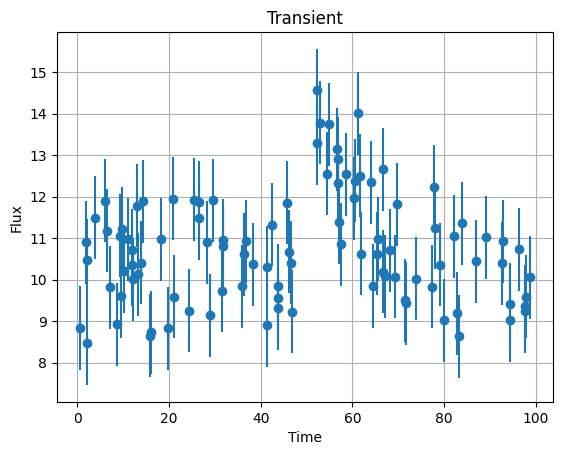

In [3]:
plt.errorbar(time, flux, yerr=error, fmt='o')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Transient')

In [4]:
# Burst
def model(t, theta):
    A, b, alpha, t0 = theta
    return np.where(t<t0, b, b + A*np.exp(-alpha*(t-t0)))


Text(0.5, 1.0, 'Transient')

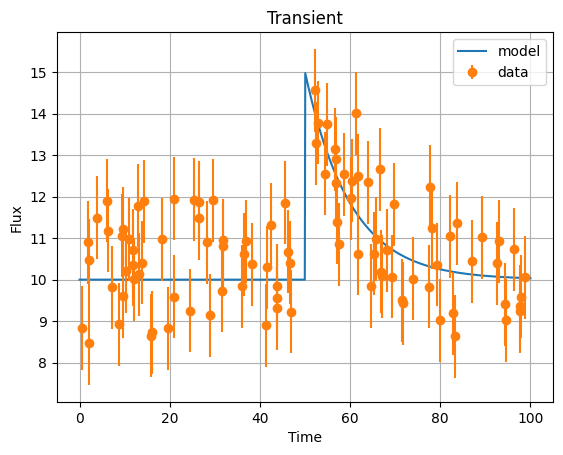

In [5]:
# Params by eye:
A = 5
b = 10
t0 = 50
alpha  = 0.1
theta_guess = A,b,alpha,t0

xgrid = np.linspace(0,100,1000)

plt.plot(xgrid, model(xgrid, theta_guess), label = 'model')
plt.errorbar(time, flux, yerr=error, fmt='o', label = 'data')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.title('Transient')

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc3`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

### Bayesian Priors, likelihood

In [6]:
#ALways use theta as first param!

#Prior
#Uniform prior for all params
#alpha is exp^-alpha
Amin, Amax = 0,50
bmin, bmax = 0, 50
alphamin , alphamax = np.exp(-5), np.exp(5)
t0min, t0max = 0, 100
def Prior(theta):
    A, b, alpha_, t0 = theta
    priorA = scipy.stats.uniform(loc = Amin, scale = Amax - Amin).pdf(A)
    priorb = scipy.stats.uniform(loc = bmin, scale = bmax - bmin).pdf(b)
    prior_t0 = scipy.stats.uniform(loc = t0min, scale = t0max - t0min).pdf(t0)
    prior_alpha = scipy.stats.loguniform.pdf(alpha_, alphamin,alphamax) #TODO: Check this
    return priorA * priorb * prior_t0 * prior_alpha

#Likelihood
def Likelihood(theta, data, model):
    x, y, yerr = data.T
    y_model = model(x, theta)
    return np.prod(scipy.stats.norm(loc = y_model, scale = yerr).pdf(y)) #TODO: Check this

#Posterior
def Posterior(theta, data, model):
    return Likelihood(theta, data, model)*Prior(theta)


### Emcee MCMC Burst Model

In [7]:
# Emcee needs log posterior
def LogPosterior(theta, data, model):
    return np.log(Posterior(theta, data, model))

ndim = len(theta_guess)  # number of parameters in the model
nwalkers = 15  # number of MCMC walkers
burn = 1000  # arbitrary number of steps for the chain to stabilise
nsteps = 8000  # number of MCMC steps to take for each walker

start_guess = theta_guess + np.random.random((nwalkers,ndim)) #initial guess per walker
print(start_guess.shape)



(15, 4)


In [8]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, args=[data, model])
sampler.run_mcmc(start_guess, nsteps)
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim) #initial trace removing for arbitrary burn-in steps

/var/folders/sp/f1ltwhln0klf22nrhl_cfvbh0000gn/T/ipykernel_8696/3764093223.py:3: RuntimeWarning: divide by zero encountered in log
  return np.log(Posterior(theta, data, model))


In [9]:
print(sampler.chain.shape) #original chain structure
print(emcee_trace.shape) #burned->removed burn-in phase arbitrarly, flatten->gruped all walkers results

(15, 8000, 4)
(105000, 4)


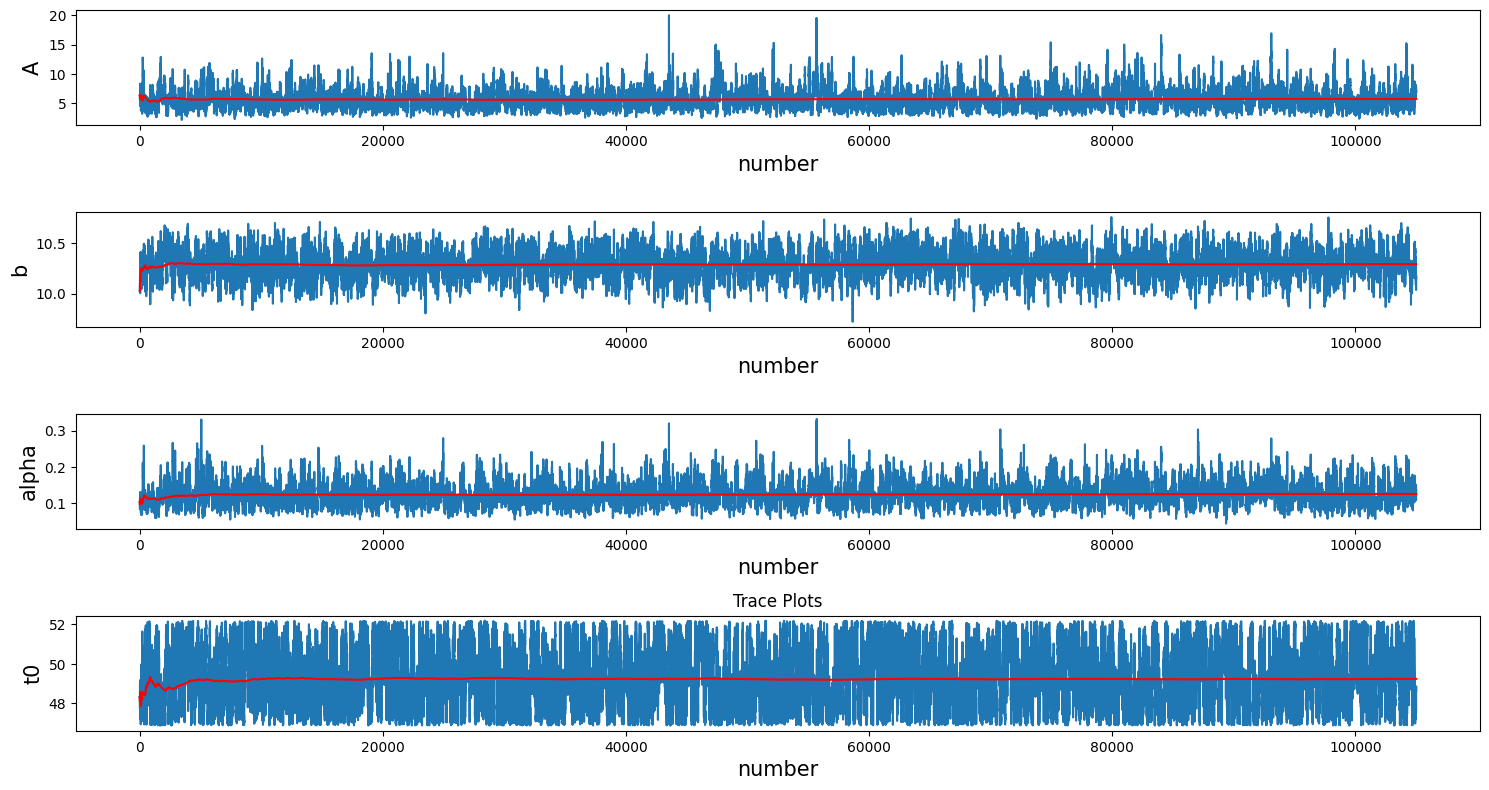

In [10]:
fig = plt.figure(figsize=(15, 8))

chainE = emcee_trace.T #[0]
M = np.size(chainE[0])
Ndata = len(data.T[0])

theta_titles = ['A', 'b', 'alpha', 't0']

i=0
nplot = 410
while(i<len(theta_guess)):
    nplot = nplot +1
    ax1 = fig.add_subplot(nplot)
    xgrid = np.linspace(1, M, M)
    plt.plot(xgrid, chainE[i])
    #ax1.axis([0, M, np.min(chainE[i]), 1.1*np.max(chainE[i])])
    plt.xlabel('number',fontsize=15)
    plt.ylabel('{}'.format(theta_titles[i]),fontsize=15)

    # plot running mean: 
    meanC = [np.mean(chainE[i][:int(N)]) for N in xgrid]
    ax1.plot(xgrid, meanC, c='red', label='chain mean') 

    i+=1

plt.title('Trace Plots')
plt.tight_layout()


4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

In [11]:
tau = sampler.get_autocorr_time()
print('Autocorrelation time: ', tau)

acceptance = sampler.acceptance_fraction
print('Acceptance fraction: ', acceptance)

flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True) #actual burnt and flatten sample
print('Shape of samples: ', flat_samples.shape)

Autocorrelation time:  [80.51194591 60.15874572 66.13001648 70.88372241]
Acceptance fraction:  [0.52425  0.536375 0.5375   0.523875 0.54     0.535375 0.52275  0.532625
 0.517875 0.531    0.541625 0.54175  0.54475  0.536    0.52325 ]
Shape of samples:  (1455, 4)


5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

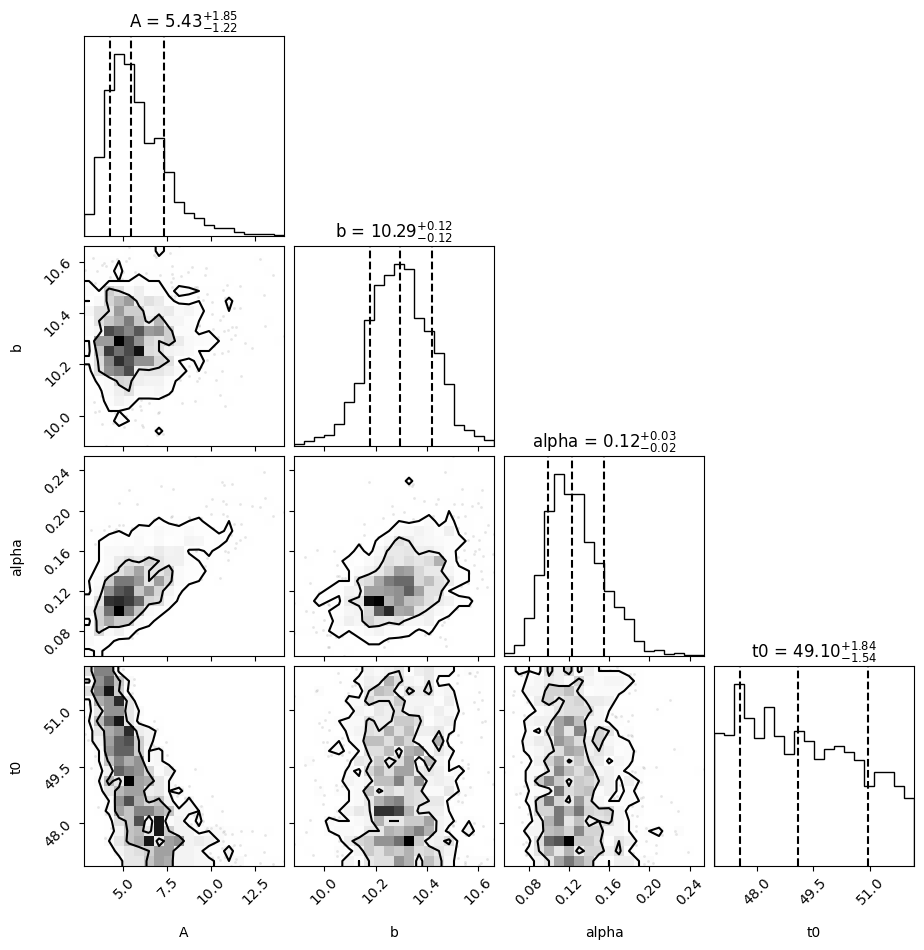

In [12]:
fig = corner.corner(
    flat_samples, labels=theta_titles, levels=[0.68,0.95], quantiles=(0.16, 0.5, 0.84), use_math_text=True, show_titles=True, 
);

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

In [13]:
chosen_samples= flat_samples[np.random.choice(len(flat_samples),size=100)] #choose randomicly 100 points

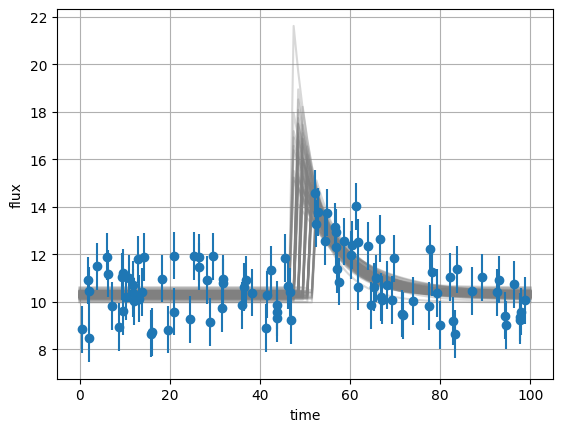

In [14]:
tgrid=np.linspace(0,100,100)

for chosen_theta in chosen_samples:

    ygrid = model(tgrid,chosen_theta)
    plt.plot(tgrid,ygrid,alpha=0.3, c='gray')
    
plt.errorbar(time,flux,yerr=error,fmt='o')
plt.xlabel("time")
plt.ylabel("flux")
plt.grid()

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 

In [15]:
for i,l in enumerate(theta_titles):
    low,med, up = np.percentile(flat_samples[:,i],[10,50,90]) 
    print(l+"\t=\t"+str(round(med,2))+"\t+"+str(round(up-med,2))+"\t-"+str(round(med-low,2)))

A	=	5.43	+2.44	-1.5
b	=	10.29	+0.16	-0.15
alpha	=	0.12	+0.04	-0.03
t0	=	49.1	+2.3	-1.77


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

### Nested Sampling Burst Model

In [16]:
import dynesty
from dynesty import plotting as dyplot

In [17]:
def prior_transform(u):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""

    priorA = scipy.stats.uniform(loc=Amin,scale=Amax-Amin).ppf(u[0])
    priorb = scipy.stats.uniform(loc=bmin,scale=bmax-bmin).ppf(u[1])
    prior_alpha = scipy.stats.loguniform.ppf(u[2],alphamin,alphamax)
    prior_t0 = scipy.stats.uniform(loc=t0min,scale=t0max-t0min).ppf(u[3])

    return [priorA, priorb, prior_alpha, prior_t0]


In [18]:
# Dynesty needs log likelihood
def LogLikelihood(theta, data, model):
    return np.log(Likelihood(theta, data, model))

In [19]:
sampler = dynesty.NestedSampler(LogLikelihood, prior_transform, len(theta_guess),logl_args=[data,model])
sampler.run_nested()
sresults = sampler.results

/var/folders/sp/f1ltwhln0klf22nrhl_cfvbh0000gn/T/ipykernel_8696/2326163411.py:4: RuntimeWarning: overflow encountered in exp
  return np.where(t<t0, b, b + A*np.exp(-alpha*(t-t0)))
/var/folders/sp/f1ltwhln0klf22nrhl_cfvbh0000gn/T/ipykernel_8696/2326163411.py:4: RuntimeWarning: overflow encountered in multiply
  return np.where(t<t0, b, b + A*np.exp(-alpha*(t-t0)))
/var/folders/sp/f1ltwhln0klf22nrhl_cfvbh0000gn/T/ipykernel_8696/623994514.py:3: RuntimeWarning: divide by zero encountered in log
  return np.log(Likelihood(theta, data, model))
48it [00:00, 87.58it/s, bound: 0 | nc: 7 | ncall: 980 | eff(%):  4.898 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.509] /var/folders/sp/f1ltwhln0klf22nrhl_cfvbh0000gn/T/ipykernel_8696/623994514.py:3: RuntimeWarning: divide by zero encountered in log
  return np.log(Likelihood(theta, data, model))
/var/folders/sp/f1ltwhln0klf22nrhl_cfvbh0000gn/T/ipykernel_8696/2326163411.py:4: RuntimeWarning: overflow encountered

In [20]:
sresults.summary()

Summary
nlive: 500
niter: 6842
ncall: 122422
eff(%):  5.997
logz: -154.951 +/-  0.295


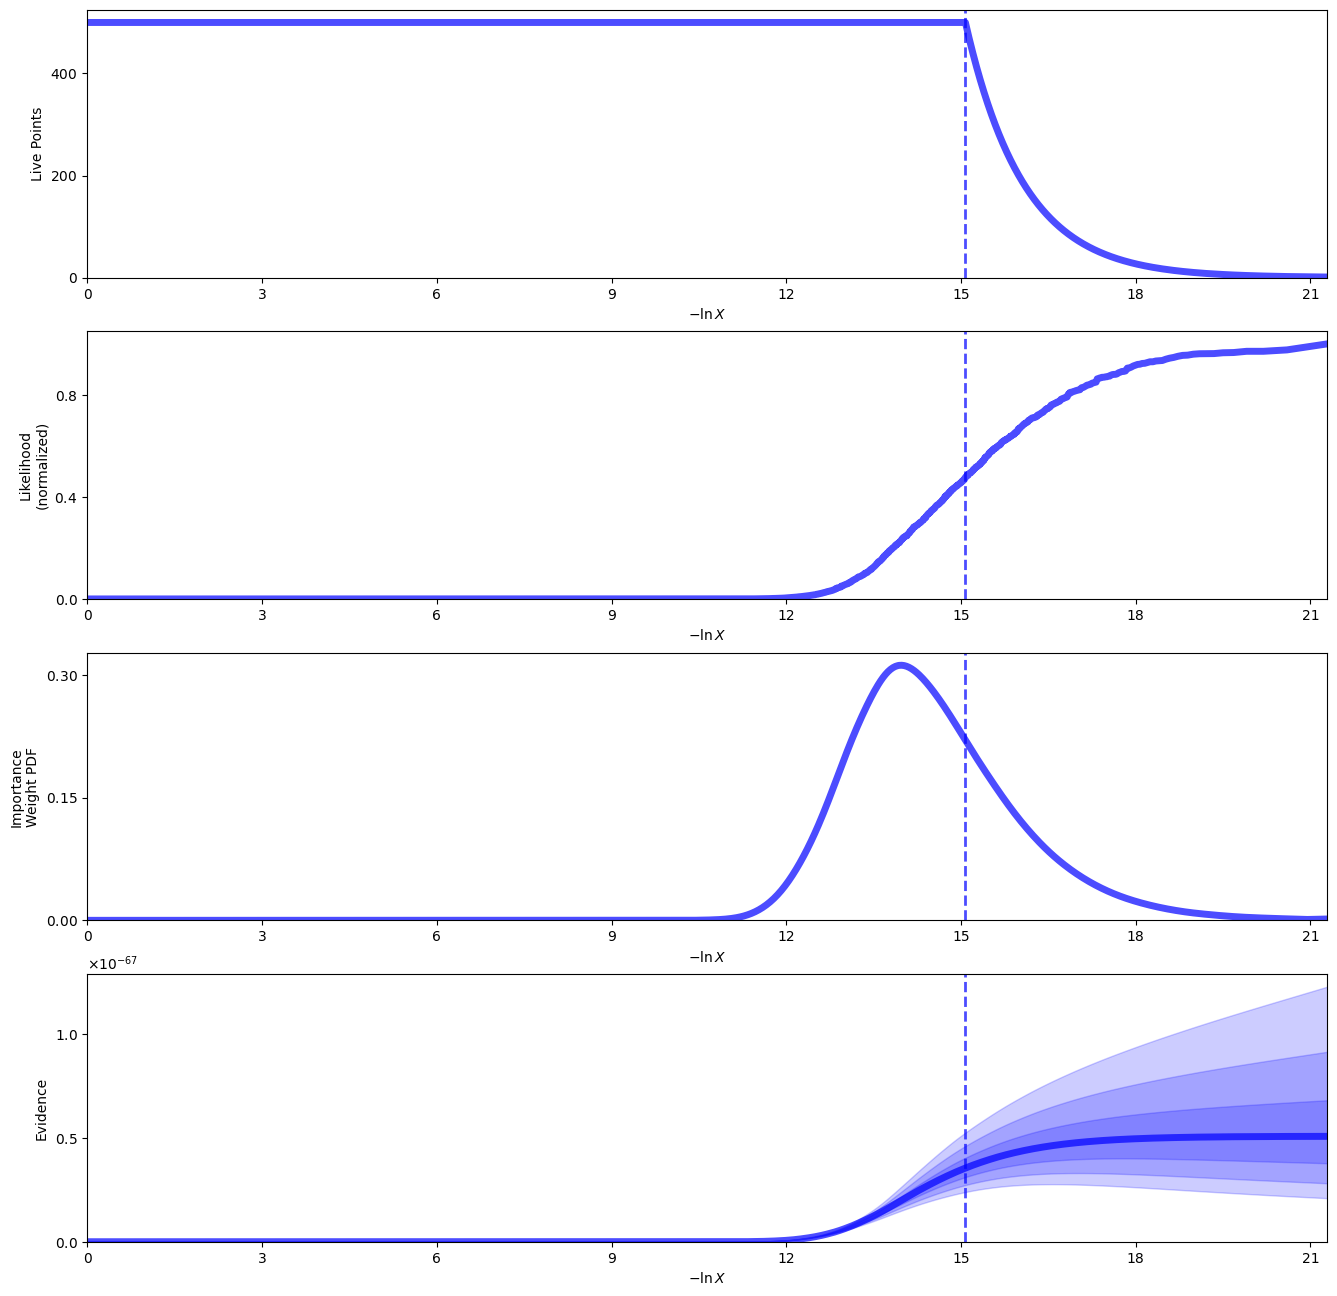

In [21]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

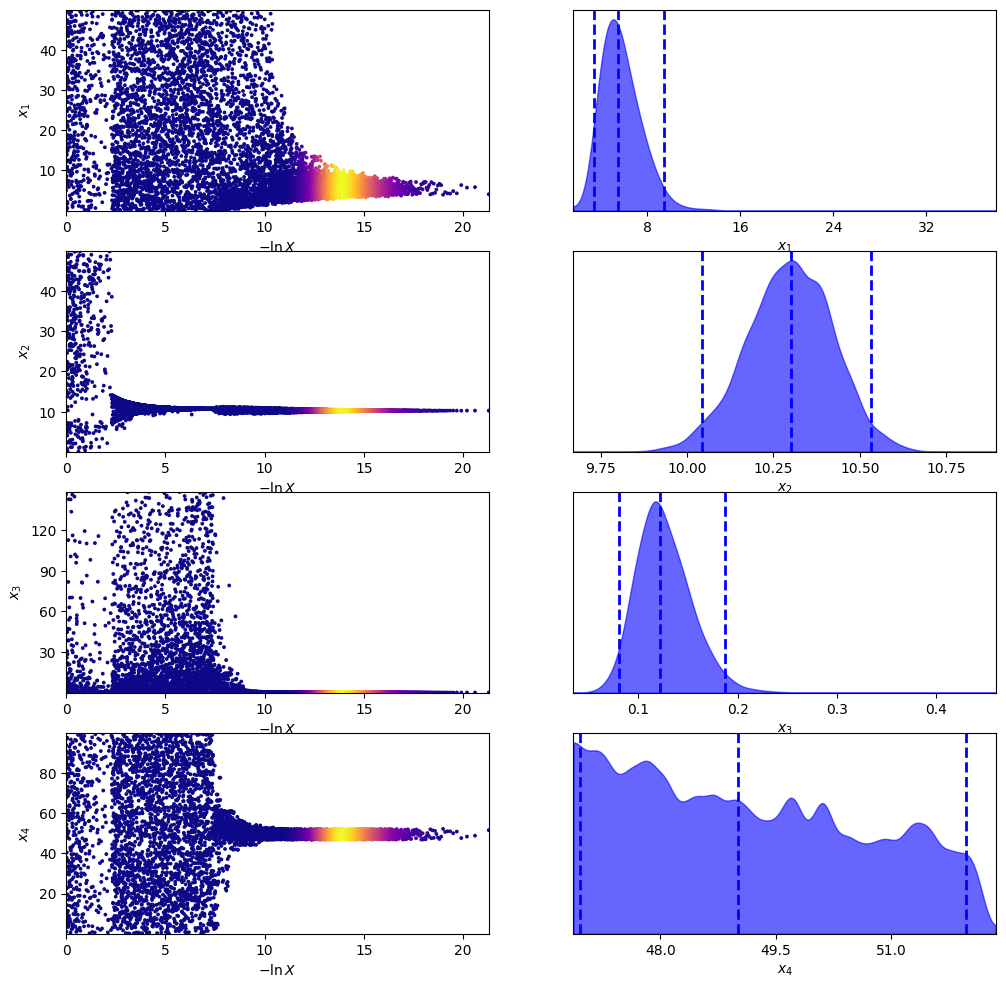

In [22]:
tfig, taxes = dyplot.traceplot(sresults)

In [23]:
from dynesty import utils as dyfunc

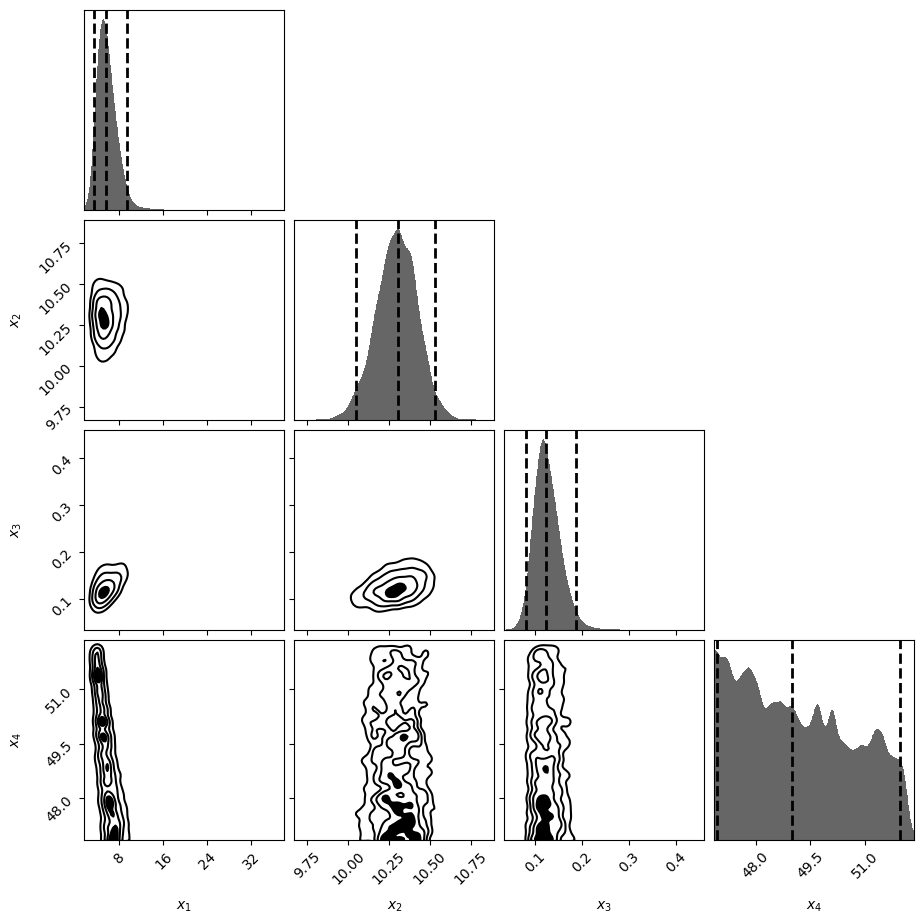

In [24]:
cfig, caxes = dyplot.cornerplot(sresults)

In [25]:
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

samples_equal = dyfunc.resample_equal(samples, weights)

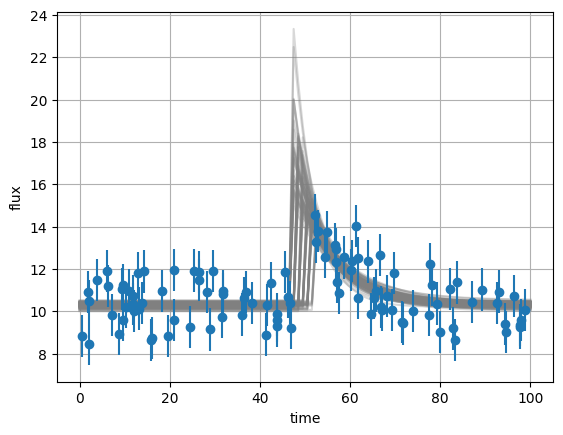

In [26]:
chosen_samples= samples_equal[np.random.choice(len(samples_equal),size=100)]

for chosen_theta in chosen_samples:

    ygrid =  model(tgrid,chosen_theta)
    plt.plot(tgrid,ygrid,alpha=0.3,c='gray')
    
plt.errorbar(time,flux,yerr=error,fmt='o')
plt.xlabel("time")
plt.ylabel("flux")
plt.grid()

In [27]:
quantiles = [dyfunc.quantile(samps, [0.1, 0.5, 0.90], weights=weights)
             for samps in samples.T]
for q,l in zip(quantiles,theta_titles):
    low,med,up=q
    print(l+"\t=\t"+str(round(med,2))+"\t+"+str(round(up-med,2))+"\t-"+str(round(med-low,2)))

A	=	5.51	+2.43	-1.55
b	=	10.3	+0.15	-0.16
alpha	=	0.12	+0.04	-0.03
t0	=	49.0	+2.44	-1.77


9) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

### Nested Sampling with Gaussian Model

In [28]:
#Gaussian Profile
def model2(t,theta):
    A , b, sigma, t0 = theta
    return b + A*np.exp(-((t-t0)**2)/(2*sigma**2))
    

Text(0.5, 1.0, 'Transient')

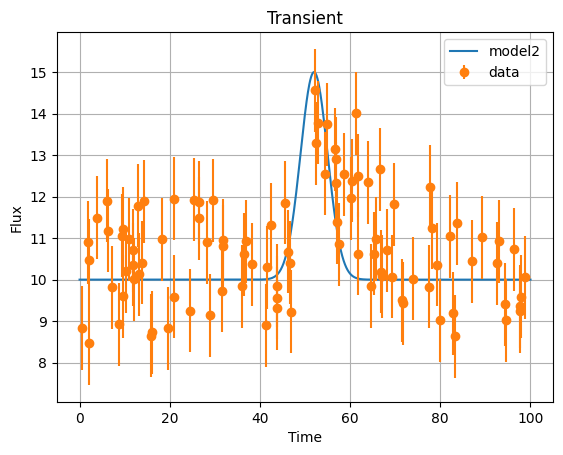

In [29]:
# Params by eye:
A = 5
b = 10
t0 = 52
sigma  = 3
theta_guess = A,b,sigma,t0

xgrid = np.linspace(0,100,1000)

plt.plot(xgrid, model2(xgrid, theta_guess), label = 'model2')
plt.errorbar(time, flux, yerr=error, fmt='o', label = 'data')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.title('Transient')

In [30]:
#Prior
#Uniform prior for all params
#sigma is exp^-(1/sigma**2)
Amin, Amax = 0,50
bmin, bmax = 0, 50
sigmamin , sigmamax = np.exp(-5), np.exp(5)
t0min, t0max = 0, 100

def Prior2(theta):
    A, b, sigma_, t0 = theta
    priorA = scipy.stats.uniform(loc = Amin, scale = Amax - Amin).pdf(A)
    priorb = scipy.stats.uniform(loc = bmin, scale = bmax - bmin).pdf(b)
    prior_t0 = scipy.stats.uniform(loc = t0min, scale = t0max - t0min).pdf(t0)
    prior_sigma = scipy.stats.loguniform.pdf(sigma_, alphamin,alphamax) #TODO: Check this
    return priorA * priorb * prior_t0 * prior_sigma

#Likelihood
#Same of before

#Posterior
def Posterior2(theta, data, model):
    return Likelihood(theta, data, model)*Prior2(theta)

In [31]:
def prior_transform(u):
    """Transforms the uniform random variables `u ~ Unif[0., 1.)`
    to the parameters of interest."""

    priorA = scipy.stats.uniform(loc=Amin,scale=Amax-Amin).ppf(u[0])
    priorb = scipy.stats.uniform(loc=bmin,scale=bmax-bmin).ppf(u[1])
    prior_sigma = scipy.stats.loguniform.ppf(u[2],sigmamin,sigmamax) #Gauss model has sigma!
    prior_t0 = scipy.stats.uniform(loc=t0min,scale=t0max-t0min).ppf(u[3])

    return [priorA, priorb, prior_sigma, prior_t0]



In [32]:
sampler2 = dynesty.NestedSampler(LogLikelihood, prior_transform, len(theta_guess),logl_args=[data,model2])
sampler2.run_nested()

/var/folders/sp/f1ltwhln0klf22nrhl_cfvbh0000gn/T/ipykernel_8696/623994514.py:3: RuntimeWarning: divide by zero encountered in log
  return np.log(Likelihood(theta, data, model))
30it [00:00, 62.62it/s, bound: 0 | nc: 15 | ncall: 900 | eff(%):  3.333 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.509]/var/folders/sp/f1ltwhln0klf22nrhl_cfvbh0000gn/T/ipykernel_8696/623994514.py:3: RuntimeWarning: divide by zero encountered in log
  return np.log(Likelihood(theta, data, model))
125it [00:01, 88.19it/s, bound: 1 | nc: 5 | ncall: 1687 | eff(%):  7.410 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.509] /var/folders/sp/f1ltwhln0klf22nrhl_cfvbh0000gn/T/ipykernel_8696/623994514.py:3: RuntimeWarning: divide by zero encountered in log
  return np.log(Likelihood(theta, data, model))
339it [00:02, 228.49it/s, bound: 2 | nc: 5 | ncall: 2429 | eff(%): 13.956 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz

In [33]:
sresults2 = sampler2.results
sresults2.summary()

Summary
nlive: 500
niter: 7601
ncall: 185603
eff(%):  4.365
logz: -160.460 +/-  0.307


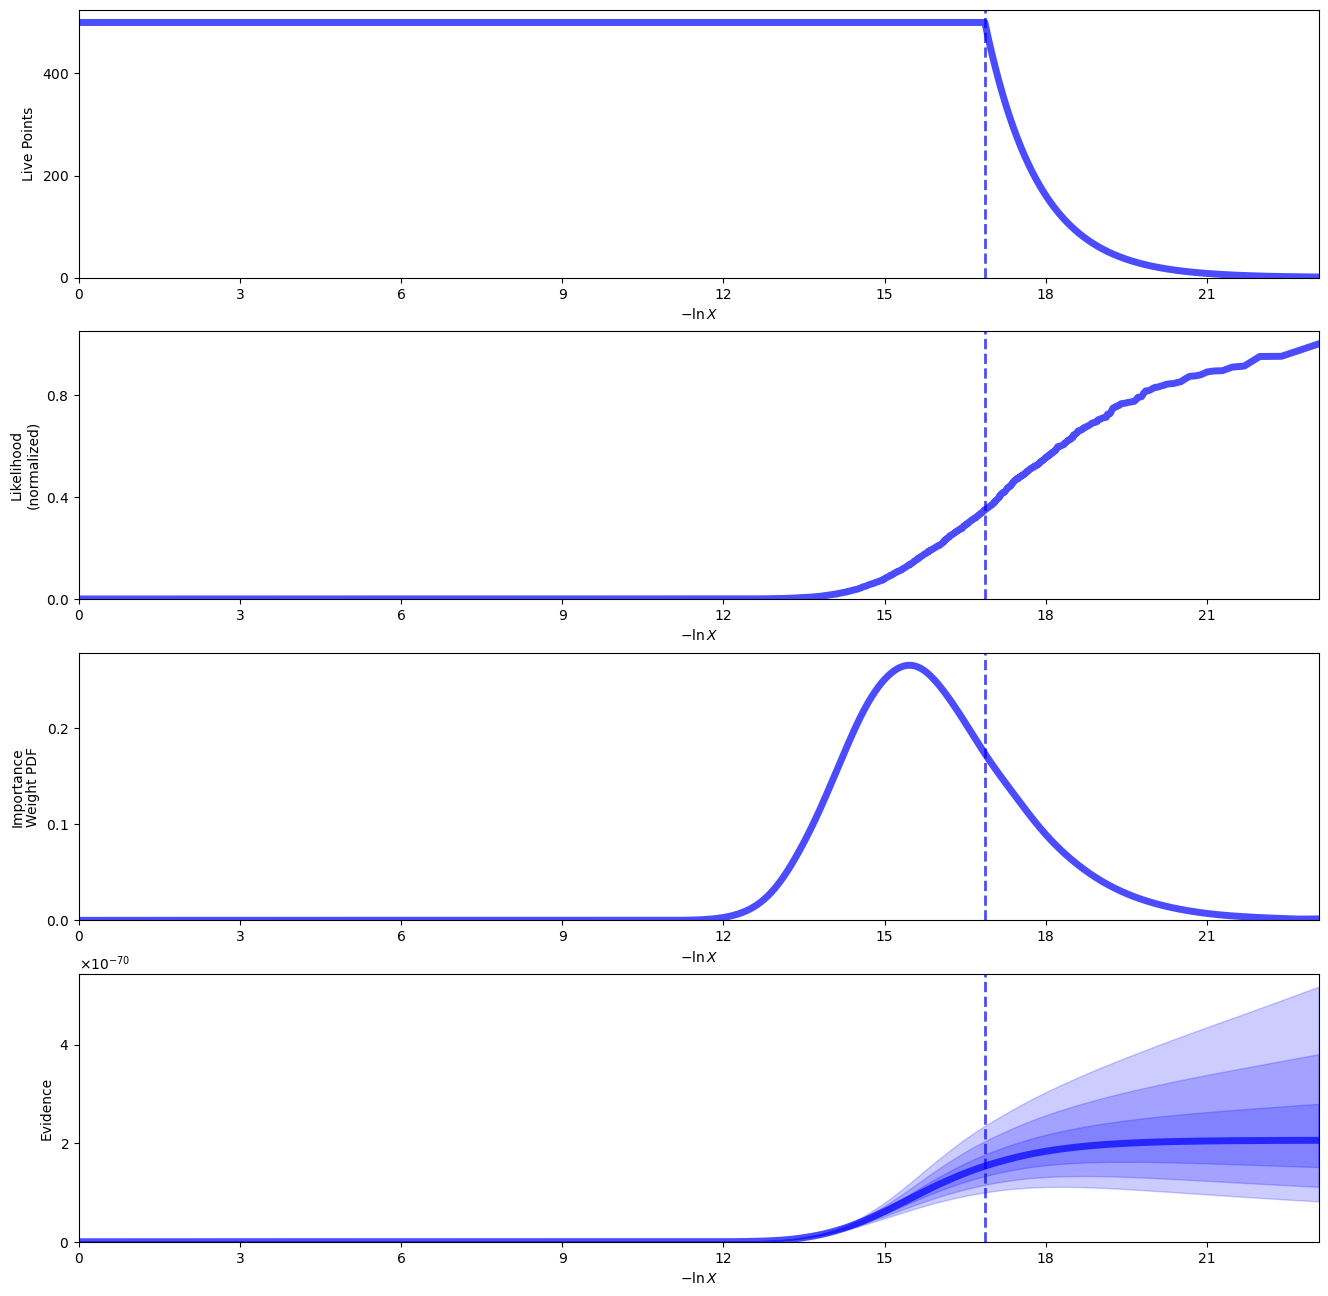

In [34]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults2)

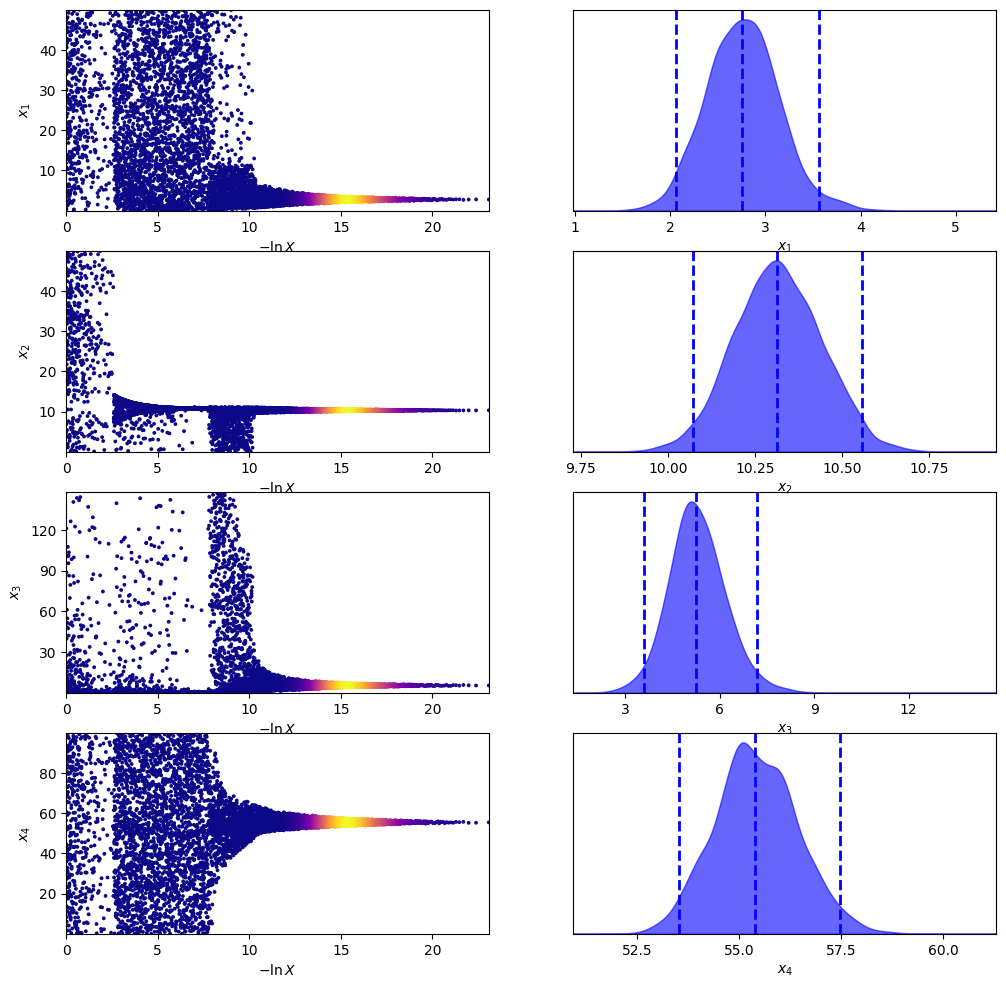

In [35]:
tfig, taxes = dyplot.traceplot(sresults2)

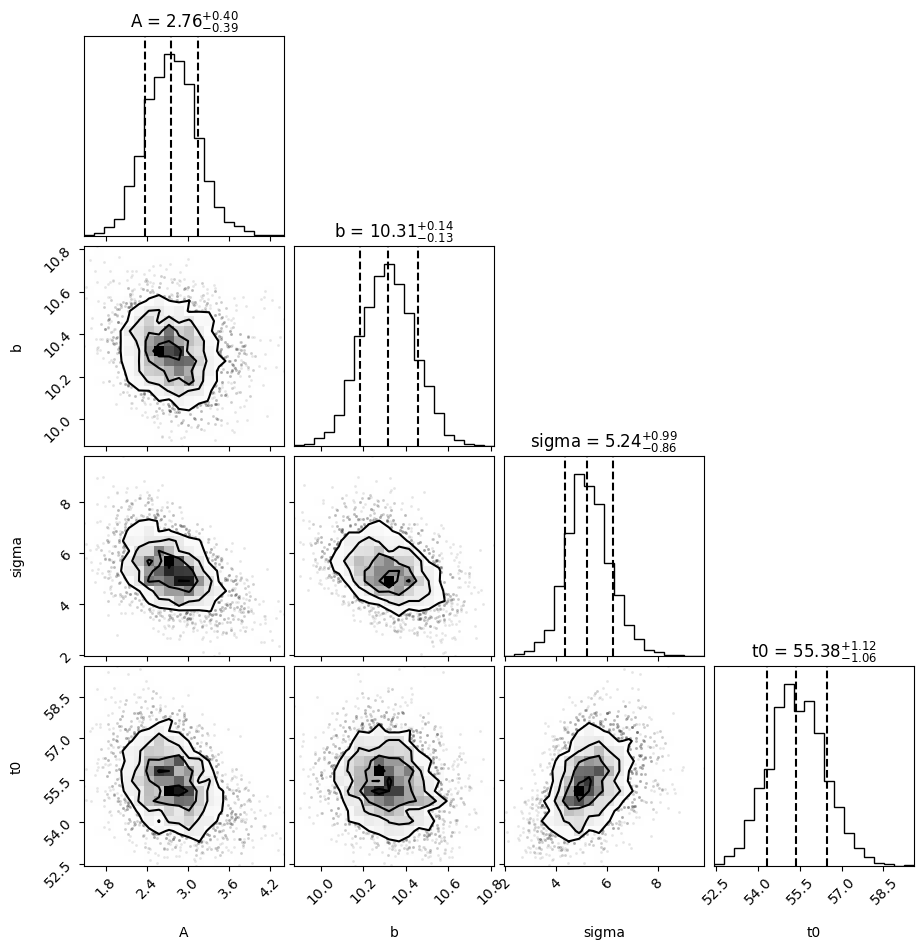

In [40]:
samples = sresults2.samples  # samples
weights = np.exp(sresults2.logwt - sresults2.logz[-1])  # normalized weights

theta_titles = ["A","b","sigma","t0"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal,labels=theta_titles, quantiles=(0.14, 0.5, 0.86), show_titles=True, use_math_text=True);

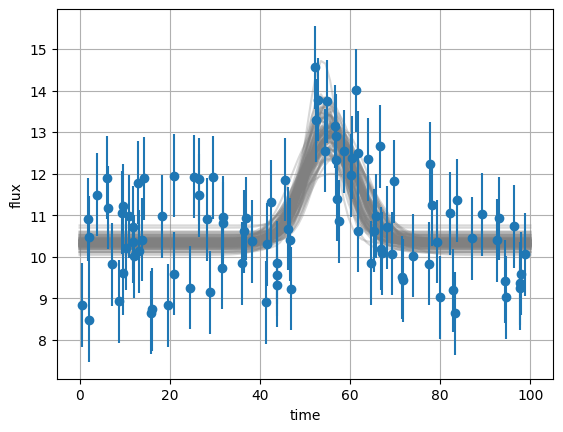

In [41]:
chosen_samples= samples_equal[np.random.choice(len(samples_equal),size=100)]

for chosen_theta in chosen_samples:

    ygrid =  model2(tgrid,chosen_theta)
    plt.plot(tgrid,ygrid,alpha=0.3,c='gray')
    
plt.errorbar(time,flux,yerr=error,fmt='o')
plt.xlabel("time")
plt.ylabel("flux")
plt.grid()

In [38]:
quantiles = [dyfunc.quantile(samps, [0.05, 0.5, 0.95], weights=weights)
             for samps in samples.T]
for q,l in zip(quantiles,theta_titles):
    low,med,up=q
    print(l+"\t=\t"+str(round(med,2))+"\t+"+str(round(up-med,2))+"\t-"+str(round(med-low,2)))

A	=	2.76	+0.64	-0.6
b	=	10.31	+0.21	-0.2
sigma	=	5.23	+1.56	-1.29
t0	=	55.38	+1.74	-1.61


### Model Comparison

10) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

In [39]:
evidence = sresults.logz[-1] #log evidence for burst model
evidence2 = sresults2.logz[-1] #log evidence for gaussian model

#Odds ratio : as both based on Bayesian approach
print('Odds (burst/gauss) = ', np.exp(evidence)/np.exp(evidence2))

Odds (burst/gauss) =  246.7664654857875


As the Odds ratio is positive and higher than 100, by Jeffreys rule of thumb there is 'very strong' evidence supporting the Burst Model.